## Imports

In [27]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
from scipy.interpolate import UnivariateSpline
import h5py
from scipy.integrate import quadrature
import pickle
import pandas as pd
from scipy.stats import chi2
from scipy.interpolate import interp1d

from plots import scientific_format, dmu_idm_dr, plot_observations, plot_varied_recoupling
from data_generation.variables import *
from scipy.signal import argrelextrema
from scipy.stats import chisquare

from observation_data.observations import *


import warnings

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# h5pydir = '/Users/nolansmyth/Dropbox/kinetic_recoupling/h5py_dat/'
h5pydir = 'h5py_dat/'

# h5pydir = '<YOUR PATH HERE>Dropbox/kinetic_recoupling/h5py_dat/'

In [4]:
plt.style.use("/Users/nolansmyth/Dropbox/kinetic_recoupling/figures/style.mplstyle")
# plt.style.use("<YOUR PATH HERE>Dropbox/kinetic_recoupling/figures/style.mplstyle")

In [5]:
# pk_delta_interp = pickle.load(open("interps/pks_delta_interp.p", "rb"))
pk_delta_interp = pickle.load(open("interps/pks_delta_interp_new.p", "rb"))


In [6]:
pk_delta_rate_interp = pickle.load(open("interps/pks_delta_interp_rate.p", "rb"))

In [7]:
#Get data for case with no recoupling
k = '1.0'
data_file=h5pydir+'class_testing_no_rec.hdf5'
with h5py.File(data_file, 'r') as f:
    tau_data = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
    delta_chi_data = np.array(f['scalar']['k='+str(k)]['delta_idm_dr'])
    phi_data = np.array(f['scalar']['k='+str(k)]['phi'])
    theta_dr_data = np.array(f['scalar']['k='+str(k)]['theta_idr'])
    theta_data = np.array(f['scalar']['k='+str(k)]['theta_idm_dr'])
    
    
    delta_chi_no_rec = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
    delta_chi_dot_no_rec = delta_chi_no_rec.derivative()
    phi_no_rec = UnivariateSpline(tau_data, phi_data, **spline_pars)
    phi_dot_no_rec = phi_no_rec.derivative()
    theta_dr_no_rec = UnivariateSpline(tau_data, theta_dr_data, **spline_pars)

    theta_chi_no_rec = UnivariateSpline(tau_data, theta_data, **spline_pars)
    theta_chi_dot_no_rec = theta_chi_no_rec.derivative()

    Pks_no_rec = np.array(f['power_spectrum']['Pk'])
    kks_no_rec = np.array(f['power_spectrum']['kk'])

    kappa_dot_data_no_rec = np.flip(np.array(f['thermodynamics']['dmu_idm_dr']))
    z_data_no_rec = np.flip(np.array(f['thermodynamics']['z']))
    thermo_tau_data_no_rec = np.flip(np.array(f['thermodynamics']['conf. time [Mpc]']))

    rho_idr_no_rec = np.array(f['background']['(.)rho_idr'])
    rho_idm_no_rec = np.array(f['background']['(.)rho_idm_dr'])
    bkg_zs_no_rec = np.array(f['background']['z'])
    clTT_no_rec = np.array(f['cmb']['tt'])
    ll_no_rec = np.array(f['cmb']['ell'])

    thermo_taus_no_rec = UnivariateSpline(np.flip(z_data_no_rec), np.flip(thermo_tau_data_no_rec), **spline_pars)

    a_data = 1/(1+z_data_no_rec)
    a = UnivariateSpline(thermo_tau_data_no_rec, a_data, **spline_pars)
    aprime = a.derivative()

In [8]:
# BM_KS = [str(round(n, 3)) for n in np.geomspace(0.1, 10, 100)]

N_points = 100  # Number of grid points in each dimension
A_rec_arr = np.logspace(12, 12, N_points)
T_rec_arr = np.logspace(np.log10(6e6), np.log10(6e1), N_points)

T_rec_arr = T_rec_arr[:-1]
A_rec_arr = A_rec_arr[1:]

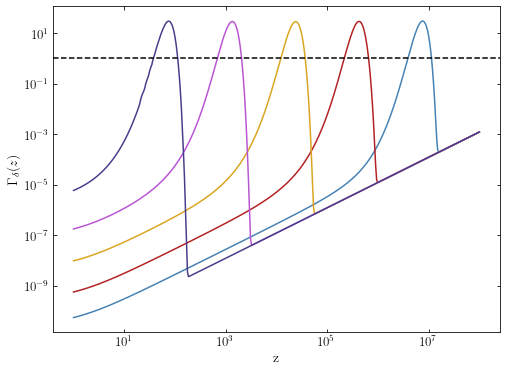

In [9]:
zs = np.logspace(0,8,400)
for T in np.logspace(np.log10(6e6), np.log10(6e1), 5):
    plt.loglog(zs, pk_delta_rate_interp((T, zs)), label = str(T))
plt.axhline(1, color='k', ls='--')
plt.xlabel('z')
plt.ylabel('$\Gamma_{\delta}(z)$')

plt.show()


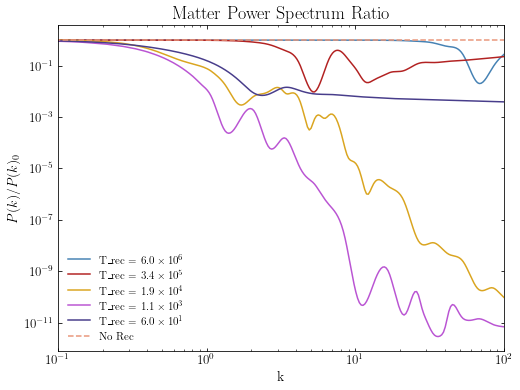

In [10]:
T_rec = T_rec_arr[18]
Ts = np.logspace(np.log10(6e6), np.log10(6e1), 5)

lines = ["-","--","-.",":"]
# plt.plot(kk, pk_delta_interp((T_rec,kk))/Pks_no_rec,  ls = lines[0%len(lines)], label='T_rec = ' + scientific_format(T_rec))

for T in Ts:
    plt.plot(kks_no_rec, pk_delta_interp((T,kks_no_rec))/Pks_no_rec,  ls = lines[0%len(lines)], label='T_rec = ' + scientific_format(T))


plt.plot(kk,Pks_no_rec/Pks_no_rec, '--', label='No Rec')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('$P(k)/P(k)_0$')
plt.title('Matter Power Spectrum Ratio')
plt.xlim(1e-1,1e2)
plt.legend()
plt.show()

In [11]:
def my_dmu_idm_dr(z, A_rec, a_idm_dr = 1, Omega0_idm_dr = 0.12038, T_rec = 6.0e5, xi_idr = 0.3, sigma_fac = 0.001):

    # sigma = sigma_fac*T_rec
    sigma = sigma_fac*T_rec*10
    # sigma = sigma_fac *T_rec**(2)*1e-5

    # base_rate = a_idm_dr * ((1+z)/(1e7))**4 * Omega0_idm_dr 
    base_rate = a_idm_dr * ((1+z)/(1e7))**2 * Omega0_idm_dr 

    T_idr = (xi_idr * 2.73) * (1+z)
    delta = T_idr - T_rec
    delta = delta/sigma
    gauss = np.exp(-pow(delta,2)/2)/np.sqrt(2*np.pi)

    return base_rate * (1 + A_rec / sigma * gauss)

In [12]:
def conformal_H(z):
    return aprime(thermo_taus_no_rec(z))/a(thermo_taus_no_rec(z))

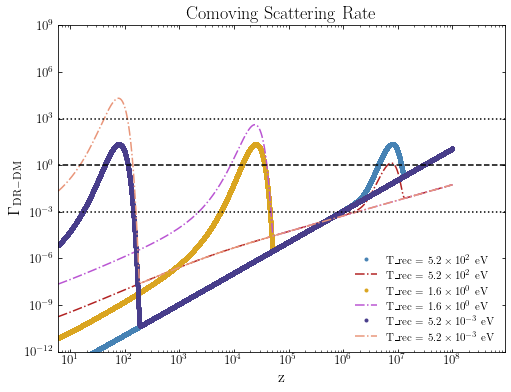

In [13]:
z_data = np.geomspace(1e-3,1e8,int(1e5))

# A_recs = [1e12, 10**(13.5), 1e15, 10**(16.5), 1e18]
# T_recs = [6e6, 6e5*np.sqrt(10), 6e5, 6e4*np.sqrt(10), 6e4]

A_recs = np.logspace(9, 14, 3)
T_recs = np.logspace(np.log10(6e6), np.log10(6e1), 3)
# T_recs = np.logspace(np.log10(1e7), np.log10(6e5), 5)


for i, T_rec in enumerate(T_recs):
    plt.plot(z_data, my_dmu_idm_dr(z_data, A_recs[i], a_idm_dr = 1, T_rec=T_recs[i], sigma_fac=0.02), '.', label='T_rec = {} eV'.format(scientific_format(ktoev*T_recs[i])))
    plt.plot(z_data, my_dmu_idm_dr(z_data, A_recs[i], a_idm_dr = 1, T_rec=T_recs[i], sigma_fac=0.02)/conformal_H(z_data), '-.', label='T_rec = {} eV'.format(scientific_format(ktoev*T_recs[i])))

plt.plot([1e-3,1e10], [1,1], 'k--')
plt.plot([1e-3,1e10], [1e-3,1e-3], 'k:')
plt.plot([1e-3,1e10], [1e3,1e3], 'k:')

plt.xlim(6e0,9e8)
plt.ylim(1e-12,1e9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\Gamma_{\mathrm{DR-DM}}$', fontsize=16)
plt.title('Comoving Scattering Rate')
plt.legend()
plt.show()

In [14]:
def recoupling_time_new(A_rec, T_rec):
    """Recoupling time in Mpc, defined as time spent above 1 during recoupling"""
    # zs = np.logspace(4, 8, 20000)
    dmus = np.array(my_dmu_idm_dr(z_data, A_rec, a_idm_dr = 1e-3, T_rec=T_rec, sigma_fac=0.02))
    # crit_idxs = np.where(abs(1 - dmus/1e-3) < 2e-2)[0]
    crit_idxs = np.where(abs(1 - dmus) < 5e-2)[0]
    if len(crit_idxs) <= 1:
        print("No recoupling found")
        return np.nan
    dec_idx = np.min(crit_idxs)
    rec_idx = np.max(crit_idxs)
    rec_duration_tau = thermo_taus_no_rec(z_data[dec_idx]).item() - thermo_taus_no_rec(z_data[rec_idx]).item()
    # print("dec_z: {}, rec_z: {}".format(z_data[dec_idx], z_data[rec_idx]))

    return rec_duration_tau

In [15]:
for i in range(len(A_recs)):
    # print(my_dmu_idm_dr(z_data, A_recs[i], a_idm_dr = 1e-3, T_rec=T_recs[i], sigma_fac=0.02))
    print(T_recs[i], recoupling_time_new(A_recs[i], T_recs[i]))

No recoupling found
6000000.000000003 nan
No recoupling found
18973.665961010287 nan
No recoupling found
60.0 nan


In [104]:
def plot_delta_recoupling(i):
    """
    Plot the rate and power spectrum for a given delta recoupling.
    """
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.subplot(211)
    T_rec = T_rec_arr[i]
    print(T_rec)
    pks_delta = pk_delta_interp((T_rec,kk))
    plt.plot(kk, pks_delta/Pks_no_rec,  ls = lines[i%len(lines)], label='T_rec = ' + scientific_format(T_rec))
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e-1, 3e1)
    # plt.ylim(0.97, 1)
    plt.xlabel("k [h/Mpc]")
    plt.ylabel("$P(k)/P(k)_0$")
    plt.legend()
    plt.title("Double Decoupling")

    plt.subplot(212)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("z")
    plt.ylabel("$\Gamma_{\mathrm{DR-DM}}$")

    zs = np.geomspace(1e-3,1e8,int(1e5))
    
    dmus = my_dmu_idm_dr(zs, np.flip(A_rec_arr)[i], a_idm_dr = 1e-3, T_rec=T_rec_arr[i], sigma_fac=0.01)
    plt.plot(
        zs,
        dmus,
        "b",
        label='T_rec = ' + scientific_format(T_rec))
    
    plt.plot([zs[-1],zs[0]], 1e-3 * np.ones(2), "--k")
    plt.plot([zs[-1],zs[0]], np.ones(2), "--k")

    plt.xlim(1e3, 1e8)
    plt.ylim(1e-10, 1e7)

    plt.legend()
    fig.tight_layout(h_pad=2)

    plt.show()


In [18]:
#sort all relevant data by ks
# constraint_ks = np.concatenate((dfBOSS["k"], dfDES["X"], dfPlanckTT["X"], dfPlanckEE["X"], dfPlanckPP["X"]))
# constraint_pks = np.concatenate((dfBOSS["P(k)"], dfDES["Y"], dfPlanckTT["Y"], dfPlanckEE["Y"], dfPlanckPP["Y"]))
# constraint_pk_y_errs = np.concatenate((yerrBOSS, yerrDES, yerrTT, yerrEE, yerrPP), axis=1)
# constraint_pk_x_errs = np.concatenate(( xerrDES, xerrTT, xerrEE, xerrPP), axis=1)

constraint_ks = np.concatenate((dfDES["X"],dfBOSS["X"]))
constraint_pks = np.concatenate((dfDES["Y"], dfBOSS["Y"]))
constraint_pk_y_errs = np.concatenate((yerrDES, yerrBOSS), axis=1)
constraint_pk_x_errs = np.concatenate((xerrDES, xerrBOSS), axis=1)

constraint_ks_sorted = sorted(constraint_ks)
constraint_pks_sorted = [x for _, x in sorted(zip(constraint_ks, constraint_pks))]

constraint_ks_sorted = sorted(constraint_ks)
constraint_pks_sorted = [x for _, x in sorted(zip(constraint_ks, constraint_pks))]
constraint_pk_y_errs_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_y_errs_sorted[0] = np.array([x for _, x in sorted(zip(constraint_ks, constraint_pk_y_errs[0]))])
constraint_pk_y_errs_sorted[1] = np.array([x for _, x in sorted(zip(constraint_ks, constraint_pk_y_errs[1]))])
constraint_pk_y_var_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_y_var_sorted[0] = constraint_pk_y_errs_sorted[0]
constraint_pk_y_var_sorted[1] = constraint_pk_y_errs_sorted[1]


constraint_pk_x_errs_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_x_errs_sorted[0] = [x for _, x in sorted(zip(constraint_ks, constraint_pk_x_errs[0]))]
constraint_pk_x_errs_sorted[1] = [x for _, x in sorted(zip(constraint_ks, constraint_pk_x_errs[1]))]
constraint_pk_x_var_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_x_var_sorted[0] = constraint_pk_x_errs_sorted[0]
constraint_pk_x_var_sorted[1] = constraint_pk_x_errs_sorted[1]

# constraint_pk_y_var_sorted = abs(constraint_pk_y_errs_sorted[0] - constraint_pk_y_errs_sorted[1])
# constraint_pk_x_var_sorted = abs(-constraint_pk_x_errs_sorted[0] + constraint_pk_x_errs_sorted[1])



In [39]:
test_pks = np.zeros(len(constraint_ks_sorted))
for i, k in enumerate(constraint_ks_sorted):
    test_pks[i] = pk_delta_interp((T_rec_arr[95],k))

In [40]:
#new chi2_statistic
interpolating_function = interp1d(constraint_ks_sorted, test_pks, kind='cubic')
y_interp = interpolating_function(constraint_ks_sorted)
dx = np.gradient(constraint_ks_sorted)
dy_dx = np.gradient(y_interp, dx)

y_total_err = np.sqrt(constraint_pk_y_var_sorted**2 + (dy_dx * constraint_pk_x_var_sorted)**2)
chi2_stat = np.sum((constraint_pks_sorted - y_interp)**2 / y_total_err**2)

p_value = 1.0 - chi2.cdf(chi2_stat, len(constraint_ks_sorted))

print(chi2_stat)
print(p_value)
if p_value < 0.05:
    print("Model does not fit data")
else:
    print("Model fits data")

141.05739147643328
0.0
Model does not fit data


In [41]:
def make_constraint_chisquare():
    chi2_grid = []
    chi2_Ts = []

    for i, Tr in enumerate(T_rec_arr):
        test_pks = np.array([pk_delta_interp((Tr,k)) for k in constraint_ks_sorted])        
        interpolating_function = interp1d(constraint_ks_sorted, test_pks, kind='cubic')
        y_interp = interpolating_function(constraint_ks_sorted)
        dx = np.gradient(constraint_ks_sorted)
        dy_dx = np.gradient(y_interp, dx)
        y_total_err = np.sqrt(constraint_pk_y_var_sorted**2 + (dy_dx * constraint_pk_x_var_sorted)**2)
        chi2 = np.sum((constraint_pks_sorted - y_interp)**2 / y_total_err**2)

        chi2_grid.append(chi2)
        chi2_Ts.append(Tr)
    return np.array(chi2_grid), np.array(chi2_Ts)


def make_constraint_grid_chisquare(chi2_grid):
    #crit_val = 36.42 #for 24 points
    crit_val = chi2.isf(0.05, len(constraint_ks_sorted))
    limit_grid = np.zeros(len(chi2_grid))
    for i in range(len(limit_grid)):
        if chi2_grid[i] > crit_val:
            limit_grid[i] = 1
    return limit_grid


In [42]:
chi2_grid,chi2_Ts = make_constraint_chisquare()
limit_grid_chi2 = make_constraint_grid_chisquare(chi2_grid)

In [43]:
crit_idx = np.min(np.where(limit_grid_chi2==1))
print("Critical temperature is Log10(T) = {}".format(round(np.log10(T_rec_arr[crit_idx]),2)))
# dmus = my_dmu_idm_dr(z_data, A_recs[i], a_idm_dr = 1e-3, T_rec=T_recs[i], sigma_fac=0.02)
dmus = my_dmu_idm_dr(z_data, A_recs[0], a_idm_dr = 1e-3, T_rec=T_recs[0], sigma_fac=0.02)

print("Peak recoupling strength = {}".format(dmus[argrelextrema(dmus, np.greater)[0][0]]))


Critical temperature is Log10(T) = 5.11
Peak recoupling strength = 0.023211236816081397


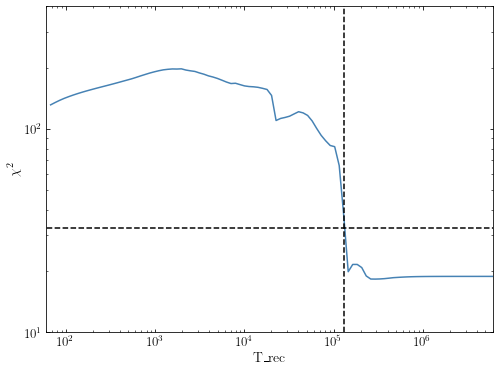

In [44]:
plt.loglog(chi2_Ts, chi2_grid)
plt.hlines(chi2.isf(0.05, len(constraint_ks_sorted)), 1e-5, 1e7, 'k', '--')
plt.vlines(T_rec_arr[crit_idx], 5e-5, 1e4, 'k', '--')
plt.xlim(6e1, 6e6)
plt.ylim(1e1, 4e2)
plt.xlabel("T_rec")
plt.ylabel(r"$\chi^2$")
plt.show()

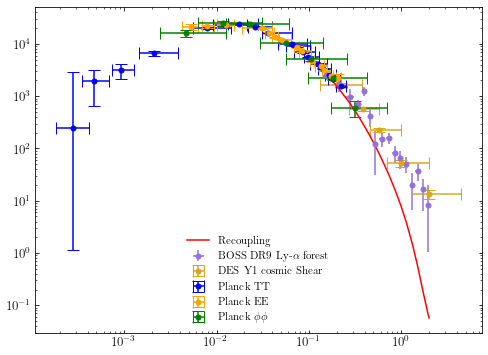

In [38]:
plt.errorbar(
    dfBOSS["X"],
    dfBOSS["Y"],
    yerr=yerrBOSS,
    xerr=xerrBOSS,
    marker="o",
    ms=5,
    color="mediumpurple",
    ls="none",
    label=r"BOSS DR9 Ly-$\alpha$ forest",
)

plt.errorbar(
    dfDES["X"],
    dfDES["Y"],
    yerr=yerrDES,
    xerr=xerrDES,
    marker="o",
    ms=5,
    color="goldenrod",
    ls="none",
    capsize=6,
    label="DES Y1 cosmic Shear",
)

plt.errorbar(
    dfPlanckTT["X"],
    dfPlanckTT["Y"],
    yerr=yerrTT,
    xerr=xerrTT,
    marker="o",
    ms=5,
    color="blue",
    ls="none",
    capsize=6,
    label="Planck TT",
)

plt.errorbar(
    dfPlanckEE["X"],
    dfPlanckEE["Y"],
    yerr=yerrEE,
    xerr=xerrEE,
    marker="o",
    ms=5,
    color="orange",
    ls="none",
    capsize=6,
    label="Planck EE",
)

plt.errorbar(
    dfPlanckPP["X"],
    dfPlanckPP["Y"],
    yerr=yerrPP,
    xerr=xerrPP,
    marker="o",
    ms=5,
    color="green",
    ls="none",
    capsize=6,
    label="Planck $\phi\phi$",
)

plt.plot(constraint_ks_sorted, test_pks, color="red", label="Recoupling")

plt.xscale("log")
plt.yscale("log")
plt.legend()

# plt.xlim(1e-2, 1e-1)
# plt.ylim(1e3, 5e4)

plt.show()

In [31]:
data_file=h5pydir+'class_model_data_no_rec.hdf5'
with h5py.File(data_file, 'r') as f:
    z_data = np.flip(np.array(f['thermodynamics']['z']))
    thermo_tau_data = np.flip(np.array(f['thermodynamics']['conf. time [Mpc]']))
    thermo_taus = UnivariateSpline(np.flip(z_data), np.flip(thermo_tau_data), **spline_pars)
    a_data = 1/(1+z_data)
    a = UnivariateSpline(thermo_tau_data, a_data, **spline_pars)
    aprime = a.derivative()

In [32]:
z_crit = 10**(4.8)/(2.73*0.3)

In [33]:
aprime(thermo_taus(z_crit))/a(thermo_taus(z_crit))
#Comoving hubble at z_crit

0.17019224906376643

In [34]:
z_crit = 10**(4.8)/(2.73)

In [35]:
#k_kinetic decoupling from equation 30 of https://arxiv.org/pdf/astro-ph/0503387.pdf
# 3.76e7 *(1e3/(100*1e9))**(1/2) *(10**(4.8)*ktoev/(30*1e6))**(1/2)
3.76e7 *(1e3/(100*1e9))**(1/2) *(10**(1.11)*ktoev/(30*1e6))**(1/2)

#This lines up with the rough value of k at which we're suppressed for 10**(4.8) recoupling!

0.022872457214377428

In [36]:
1e-2/(aprime(thermo_taus(z_crit))/a(thermo_taus(z_crit)))

0.18687817207459445

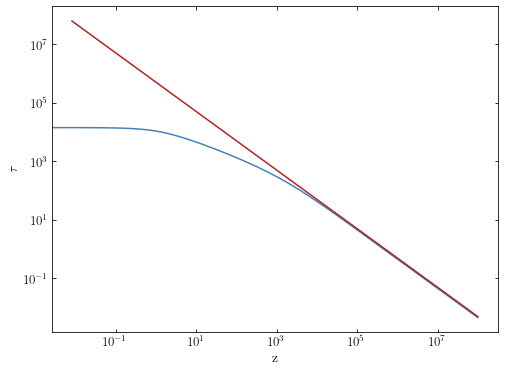

In [37]:
plt.loglog(z_data, thermo_taus_no_rec(z_data))

plt.loglog(z_data,5e5*z_data**(-1))

plt.xlabel('z')
plt.ylabel(r'$\tau$')

plt.show()


## Generate Data (shouldn't need to touch unless re-running CLASS)

In [1]:
from classy import Class

In [2]:
def getPk(classObj):
    kk = np.logspace(-4,np.log10(pk_max),500) # k in h/Mpc
    Pk = [] # P(k) in (Mpc/h)**3
    h = classObj.h() # get reduced Hubble for conversions to 1/Mpc
    for k in kk:
        Pk.append(classObj.pk(k*h,z_pk)*h**3) # function .pk(k,z)
    return Pk;

def getPkRatio(classObj1, classObj2):
    #Returns the ratio of the power spectrum of 1 to 2
    return[getPk(classObj1)[i]/getPk(classObj2)[i] for i in range(len(kk))]
    

def getdmu_idm_dr(classObj):
    return classObj.get_thermodynamics()['dmu_idm_dr']
    
def getzs(classObj):
    return classObj.get_thermodynamics()['z']

def getH(classObj):
    zs = np.flip(classObj.get_background()['z'])
    Hs = np.flip(classObj.get_background()['H [1/Mpc]'])
    return UnivariateSpline(zs, Hs, k=1.0, s=0.0)


def getDat(classObj):
    dmu_idm_dr = getdmu_idm_dr(classObj);
    zs = getzs(classObj)
    Hspline = getH(classObj)
    
    return dmu_idm_dr, zs, Hspline

# def my_dmu_idm_dr(z, A_rec, a_idm_dr = 1, Omega0_idm_dr = 0.12038, T_rec = 6.0e5, h =0.67556, xi_idr = 0.3 ):
#     base_rate = a_idm_dr * ((1+z)/(1e7))**4 * Omega0_idm_dr * h**2 

#     if T_rec >= (xi_idr * 2.73) * (1+z) and (xi_idr*2.73) * (1+z) > T_rec*0.99:
#         return base_rate*(1+A_rec)
#     else:
#         return base_rate

def save_class_obj(class_obj,A_rec):
    model = class_obj
    data_file=h5pydir+'class_model_data_saturation' +'%.2e'%A_rec+'.hdf5'
    with h5py.File(data_file, 'w') as f:    
        # Scalar group
        data = model.get_perturbations()['scalar']
        sub_group = f.create_group('scalar')
        for i, k in enumerate(BM_KS):
            sub_sub_group = sub_group.create_group(f'k={k}')
            d = data[i]
            for key, val in d.items():
                sub_sub_group.create_dataset(key, data=val)
        
        # Background group
        data = model.get_background()
        sub_group = f.create_group('background')
        for key, val in data.items():
            sub_group.create_dataset(key, data=val)
        
        # Thermo group
        data = model.get_thermodynamics()
        sub_group = f.create_group('thermodynamics')
        for key, val in data.items():
            sub_group.create_dataset(key, data=val)

        # Power Spectrum group
        data = getPk(model)
        sub_group = f.create_group('power_spectrum')
        sub_group.create_dataset('kk', data=kk)
        sub_group.create_dataset('Pk', data=data) 

In [30]:
commonset = {
    'omega_b': 0.022032,
    'omega_cdm': omega0_cdm,
    'h': 0.67556,
    'A_s': 2.215e-9,
    'n_s': 0.9619,
    'tau_reio': 0.0925,
    'output': 'tCl,pCl,lCl,mPk',
    'lensing': 'yes',
    'P_k_max_1/Mpc': pk_max,
    'z_pk': 0.0,
    'k_output_values':'10',
}

idrset = {
    # Dark matter/radiation parameters
    'f_idm_dr': f_idm_dr, #Amount of dm that is interacting
    'xi_idr': 0.3, 
    'stat_f_idr': 0.875, #fermionic
    # 'nindex_idm_dr': 4.0, 
    'nindex_idm_dr': 2.0,
    'm_idm': 1.0e3,
    # Scattering rate parameters
    'a_idm_dr': 1.0e2,
    'rec_case': 4, #1 = power, 2 = Theta, 3 = delta function, 4 = no recoupling 
}

In [8]:
# A_recs = np.logspace(12, 12, 3)
# T_recs = np.logspace(np.log10(6e6), np.log10(6e1), 3)


A_recs = np.logspace(9, 14, 3)
T_recs = np.logspace(np.log10(6e6), np.log10(6e1), 3)

In [15]:
A_rec = 1e10
T_rec = 6e4
sigma_fac = 0.02

cos = Class()
cos.set(commonset)
cos.set(idrset)
cos.set({
    'rec_case': 3,
    'A_rec':A_rec,
    'T_rec':T_rec,
    'sigma' : sigma_fac*T_rec, #Gaussian width
    'perturbations_verbose' : 3,
    })
cos.compute() 


In [33]:
A_rec = 1e10
T_rec = 6e2
sigma_fac = 0.02

cos2 = Class()
cos2.set(commonset)
cos2.set(idrset)
cos2.set({
    'rec_case': 3,
    'A_rec':A_rec,
    'T_rec':T_rec,
    'sigma' : sigma_fac*T_rec, #Gaussian width
    'perturbations_verbose' : 3,
    })
cos2.compute() 

In [ ]:
A_rec = 1e14
T_rec = 6e1
sigma_fac = 0.02

cos3 = Class()
cos3.set(commonset)
cos3.set(idrset)
cos3.set({
    'rec_case': 3,
    'A_rec':A_rec,
    'T_rec':T_rec,
    'sigma' : sigma_fac*T_rec*20 #Gaussian width
    })
cos3.compute() 

In [ ]:
A_rec = 1e14
T_rec = 6e1
sigma_fac = 0.02

cos4 = Class()
cos4.set(commonset)
cos4.set(idrset)
cos4.set({
    'rec_case': 3,
    'A_rec':A_rec,
    'T_rec':T_rec,
    'sigma' : sigma_fac*T_rec*20, #Gaussian width
    'a_idm_dr': 1.0e2,
    })
cos4.compute() 


In [ ]:
LambdaCDM = Class()
LambdaCDM.set(commonset)
LambdaCDM.compute()
LambdaCDMPk = getPk(LambdaCDM)

In [27]:
dmus = getdmu_idm_dr(cos)
dmus2 = getdmu_idm_dr(cos2)
# dmus3 = getdmu_idm_dr(cos3)
# dmus4 = getdmu_idm_dr(cos4)
zs = getzs(cos)
pks = getPk(cos)
pks2 = getPk(cos2)
# pks3 = getPk(cos3)
# pks4 = getPk(cos4)

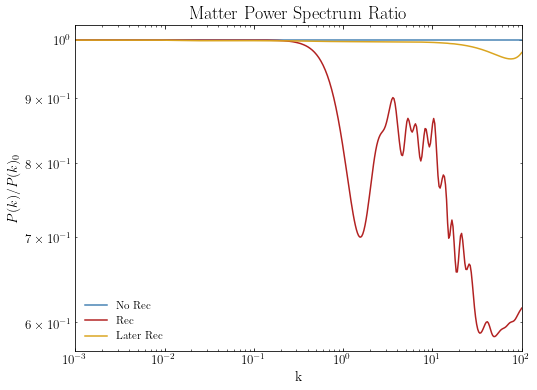

In [28]:
#n index = 2
plt.plot(kk,Pks_no_rec/Pks_no_rec, label='No Rec')
plt.plot(kk,pks/Pks_no_rec, label='Rec')
plt.plot(kk,pks2/Pks_no_rec, label='Later Rec')
# plt.plot(kk,pks3/Pks_no_rec, label='Longer Rec')
# plt.plot(kk,pks4/Pks_no_rec, label='Later Dec')


plt.yscale('log')
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('$P(k)/P(k)_0$')
plt.title('Matter Power Spectrum Ratio')
plt.xlim(1e-3,1e2)
plt.legend()
plt.show()

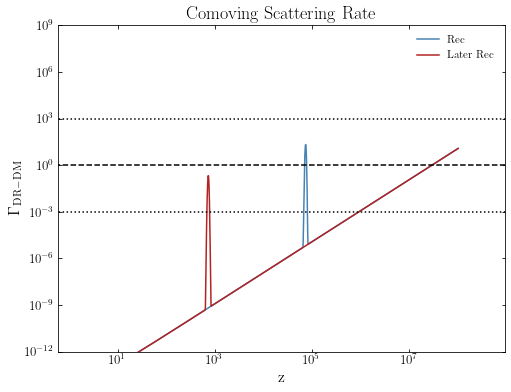

In [29]:
#n index = 2
plt.plot(zs, dmus, label='Rec')
plt.plot(zs, dmus2, label='Later Rec')
# plt.plot(zs, dmus3, label='Longer Rec')
# plt.plot(zs, dmus4, label='Later Dec')


plt.plot([1e-3,1e10], [1,1], 'k--')
plt.plot([1e-3,1e10], [1e-3,1e-3], 'k:')
plt.plot([1e-3,1e10], [1e3,1e3], 'k:')

plt.xlim(6e-1,9e8)
plt.ylim(1e-12,1e9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\Gamma_{\mathrm{DR-DM}}$', fontsize=16)
plt.title('Comoving Scattering Rate')
plt.legend()
plt.show()

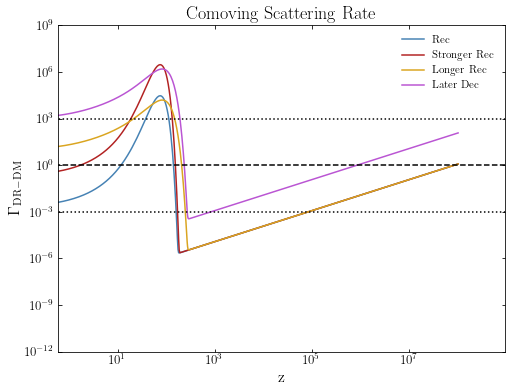

In [157]:
#n index = 1
plt.plot(zs, dmus, label='Rec')
plt.plot(zs, dmus2, label='Stronger Rec')
plt.plot(zs, dmus3, label='Longer Rec')
plt.plot(zs, dmus4, label='Later Dec')


plt.plot([1e-3,1e10], [1,1], 'k--')
plt.plot([1e-3,1e10], [1e-3,1e-3], 'k:')
plt.plot([1e-3,1e10], [1e3,1e3], 'k:')

plt.xlim(6e-1,9e8)
plt.ylim(1e-12,1e9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\Gamma_{\mathrm{DR-DM}}$', fontsize=16)
plt.title('Comoving Scattering Rate')
plt.legend()
plt.show()

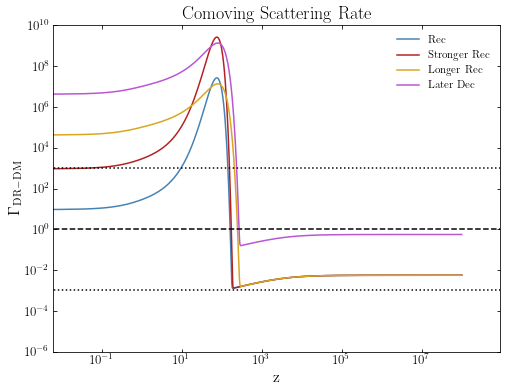

In [160]:
plt.plot(zs, dmus/conformal_H(zs), label='Rec')
plt.plot(zs, dmus2/conformal_H(zs), label='Stronger Rec')
plt.plot(zs, dmus3/conformal_H(zs), label='Longer Rec')
plt.plot(zs, dmus4/conformal_H(zs), label='Later Dec')


plt.plot([1e-3,1e10], [1,1], 'k--')
plt.plot([1e-3,1e10], [1e-3,1e-3], 'k:')
plt.plot([1e-3,1e10], [1e3,1e3], 'k:')

plt.xlim(6e-3,9e8)
plt.ylim(1e-6,1e10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\Gamma_{\mathrm{DR-DM}}$', fontsize=16)
plt.title('Comoving Scattering Rate')
plt.legend()
plt.show()

In [ ]:
idrNoRec = Class()
idrNoRec.set(commonset)
idrNoRec.set(idrset)

idrNoRec.compute()